GAN: Generative Adversarial Model can generate artificial MRI images of different contrast levels from existing MRI.

Problem statement - To Generate handwritten digit images using MNIST dataset.

Application of GAN: 
* StyleGAN
* GauGAN
* FashionGAN

Loss function used in GAN: 
* Discriminator loss
* Generator loss

GAN, when used to generate images with the help of a deep convolutional network, is termed as DCGAN (Deep Convolutional Generative Adversarial Network). Hence, all the properties of basic GAN are applied to DCGAN in the same manner. A DCGAN works similarly to GAN, but it specifically focuses on using convolutional neural networks in the place of those fully-connected networks. Conv nets, in general, find areas of correlation within an image, that is, they look for spatial correlations.

Steps :
1. Importing Libraries
2. Data Loading and Visualisation
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF of Generated Images    

Architecture of GANs:

GAN has two components - The generator and the discriminator

The generator takes noise input and tries to convert it into a realistic-looking output, whereas the discriminator tries to classify input data into real or fake.

The generator is a de convolutional neural network and the discriminator is a traditional classifier convolutional neural network (CNN) when you use GAN to generate images.

Both the components force each other to become better, thus working as adversaries.

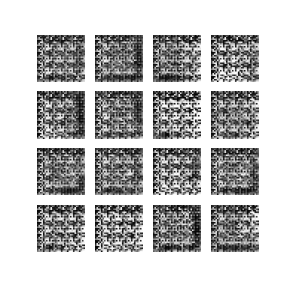

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My Drive/GAN

/content/drive/My Drive/GAN


### Importing the libraries

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import imageio
from IPython import display
from skimage.transform import resize
from tensorflow.keras.utils import plot_model

### Data loading and visualisation

#### Load the mnist data

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

5
(28, 28)


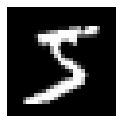

In [5]:
plt.figure(figsize=(2, 2))
plt.imshow(train_images[0], cmap='gray')
plt.axis('off')
print(train_labels[0])
print(train_images[0].shape)

Data preprocessing is a common step that is followed after loading the data. One of the important steps while working with image data, is image normalisation.

### Data preprocessing
1. Normalization of images
2. Resize images
3. Reshape images
4. Shuffle data

#### Declare buffer size, batch size and dimensions of noise

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 2048
NOISE_DIM = 100

#### Normalisation of images between [-1, 1]

In [7]:
train_dataset = (train_images/127.5)-1.0

#### Resize images to size (32, 32)

In [8]:
train_images = np.zeros((BUFFER_SIZE, 32, 32))
for index, img in enumerate(train_dataset):
    train_images[index, :, :] = resize(img, (32, 32))

5
(32, 32)


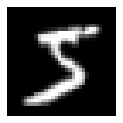

In [9]:
plt.figure(figsize=(2, 2))
plt.imshow(train_images[0], cmap='gray')
plt.axis('off')
print(train_labels[0])
print(train_images[0].shape)

#### Reshape images to add channel dimension

In [10]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 1).astype('float32')

#### Batch and shuffle the data
Shuffle - Randomly shuffles the elements of this dataset.
Batch - Combines consecutives elements of this dataset into batches.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE, seed=42).batch(BATCH_SIZE)

(-0.5, 31.5, 31.5, -0.5)

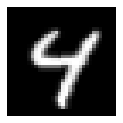

In [12]:
sample = next(iter(train_dataset))
plt.figure(figsize=(2, 2))
plt.imshow(sample[0].numpy()[:, :, 0], cmap='gray')
plt.axis('off')

### Model building
1. Generator Model building - using Transposed convolutional layers
2. Discriminator Model building

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*128, use_bias=False, input_shape=(NOISE_DIM, )))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((4, 4, 128)))
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), use_bias=False, padding='same', 
                                             activation='tanh'))
    
    return model

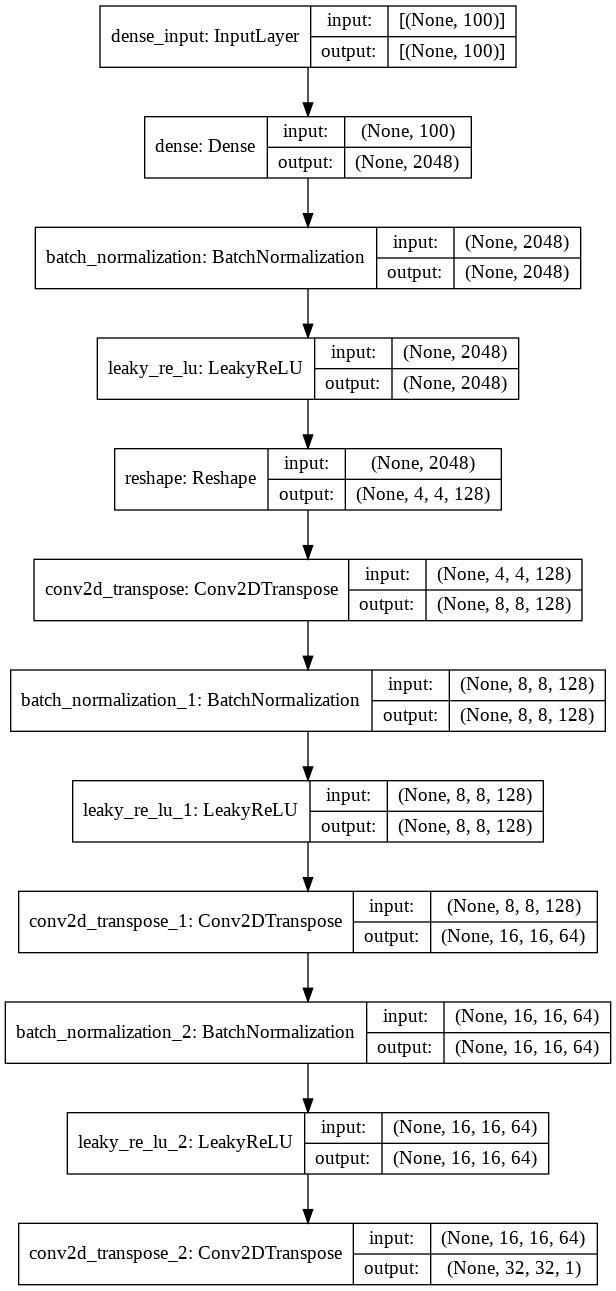

In [14]:
generator = make_generator_model()
plot_model(generator, show_shapes=True, show_layer_names=True, to_file='model_plot1.png')

#### Generate image through a raw model

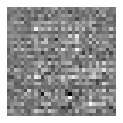

In [15]:
constant_noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(constant_noise, training=False)

plt.figure(figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), use_bias=False, input_shape=[32, 32, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(1, (10, 10), strides=(1, 1)))
    
    model.add(tf.keras.layers.Flatten())
    
    return model

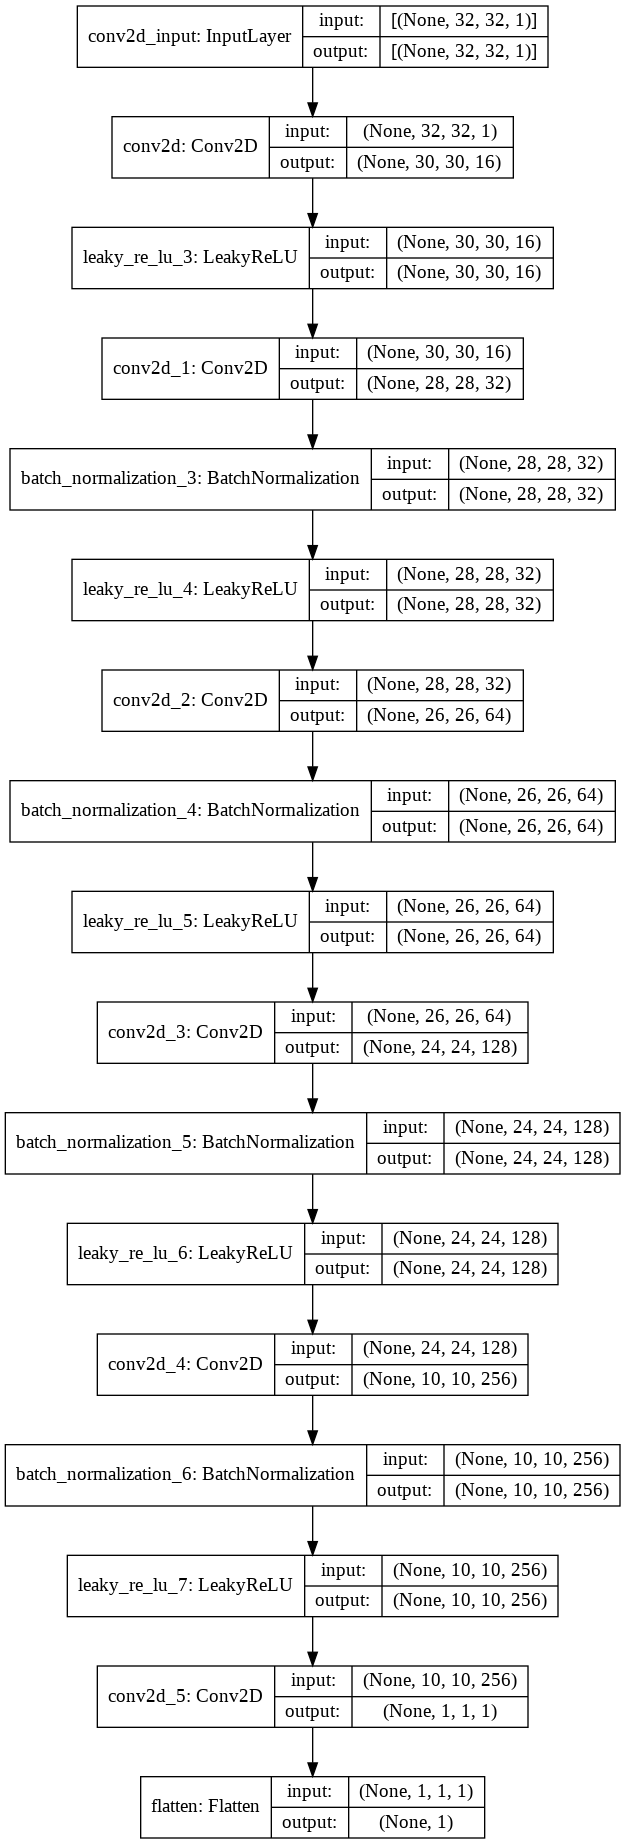

In [17]:
discriminator = make_discriminator_model()
plot_model(discriminator, show_shapes=True, show_layer_names=True, to_file='model_plot2.png')

In [18]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00197052]], shape=(1, 1), dtype=float32)


### Model Training
1. Loss type
2. Discriminator loss
3. Generator loss
4. Optimizer
5. Checkpoint initialization
6. Training flow

Declare binary cross entropy loss since we will calculate loss on discriminator which is a classifier.

In [19]:
cross_entopy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Calculate discriminator loss
It consists of two types of losses
1. Loss on real data
2. Loss on fake data

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entopy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entopy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

#### Calculate generator loss

In [21]:
def generator_loss(fake_output):
    return cross_entopy(tf.ones_like(fake_output), fake_output)

#### Adam optimizer

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
EPOCHS = 50

#### Checkpoint initialization

In [24]:
if not os.path.isdir('generated_images'):
    os.mkdir('generated_images')
    
checkpoint_dir = './training_checkpoints'
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                          discriminator_optimizer=discriminator_optimizer, 
                          generator=generator, discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!!")

Latest checkpoint restored!!!


#### Training flow

In [25]:
@tf.function
def train_step(images):
    #take noise
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    #to track the gradients for calculation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generate fake image from noise
        generated_images = generator(noise, training=True)
        
        #check discriminator's output for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        #generator's loss on fake & discriminator's loss on both real and fake
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    #calculate the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    #apply gradients in the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [26]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

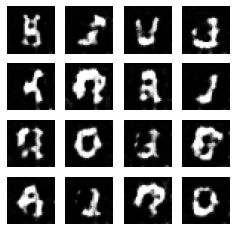

Saving checkpoint for epoch 50 at ./training_checkpoints/ckpt-78


In [27]:
for epoch in range(1, EPOCHS+1):    
    for image_batch in train_dataset:
        train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generating a GIF of Generated Images

In [28]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [29]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-jdtdqsnp
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-jdtdqsnp
     |████████████████████████████████| 1.0MB 14.2MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.01deadd830943879a6b90733ce3481e105b816620_-cp37-none-any.whl size=153744 sha256=7321ed71ef8661a898a7adf18e32850a8205616e05803a7f0d2eab11ce0d3cfa
  Stored in directory: /tmp/pip-ephem-wheel-cache-gig7na36/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [30]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.